In [1]:
from SingleAgent import SingleRLAgent
from MultiAgentEnvironment import MultiAgentEnvironment
import matplotlib.pyplot as plt
from RLTrainer import demonstrate_model
from DQN_Agent_Single import DQN_Agent_Single
from DQN_Agent_Double import DQN_Agent_Double
import pytorch_utils as ptu
from QNets import N_Concat_CNNs
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display, update_display
import ipywidgets as widgets
import imageio
import time
import random
import numpy as np
from collections import namedtuple 
from collections import deque
import pickle
import torch

Device set to : cpu


/home/silvester/anaconda3/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 6050). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [9]:
data_dir = '/home/silvester/programming/rl-single-agent-numbers/counting-agents/src/../data/'

Working with max  3  objects


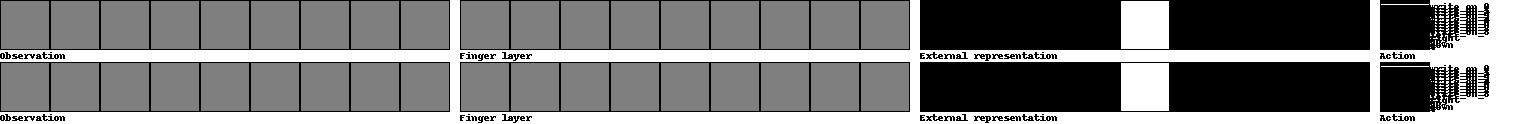

In [3]:
##############
## Static Environment Image
###################

obs_ext_shape = (4,1)
agent_params = {
    'single_or_multi_agent': 'multi',
    'task': 'classify',
    'external_repr_tool': 'WriteCoord',
    'observation': 'spatial',
    'max_objects': 3,
    'obs_shape': obs_ext_shape,
    'ext_shape': obs_ext_shape,
    'max_episode_length': 8,
    'curriculum_learning': False
}



if(agent_params['single_or_multi_agent'] == 'multi'):
    env = MultiAgentEnvironment(agent_params)
    env.agents[0].check_reward = False
if(agent_params['single_or_multi_agent'] == 'single'):
    env = SingleRLAgent(agent_params)
    env.check_reward = False
    
#env.max_episode_length = 7
#env.reset()
display(env.render(), display_id='model_demo')
env.step(['down', 'write_on_2'])
update_display(env.render(), display_id='model_demo')

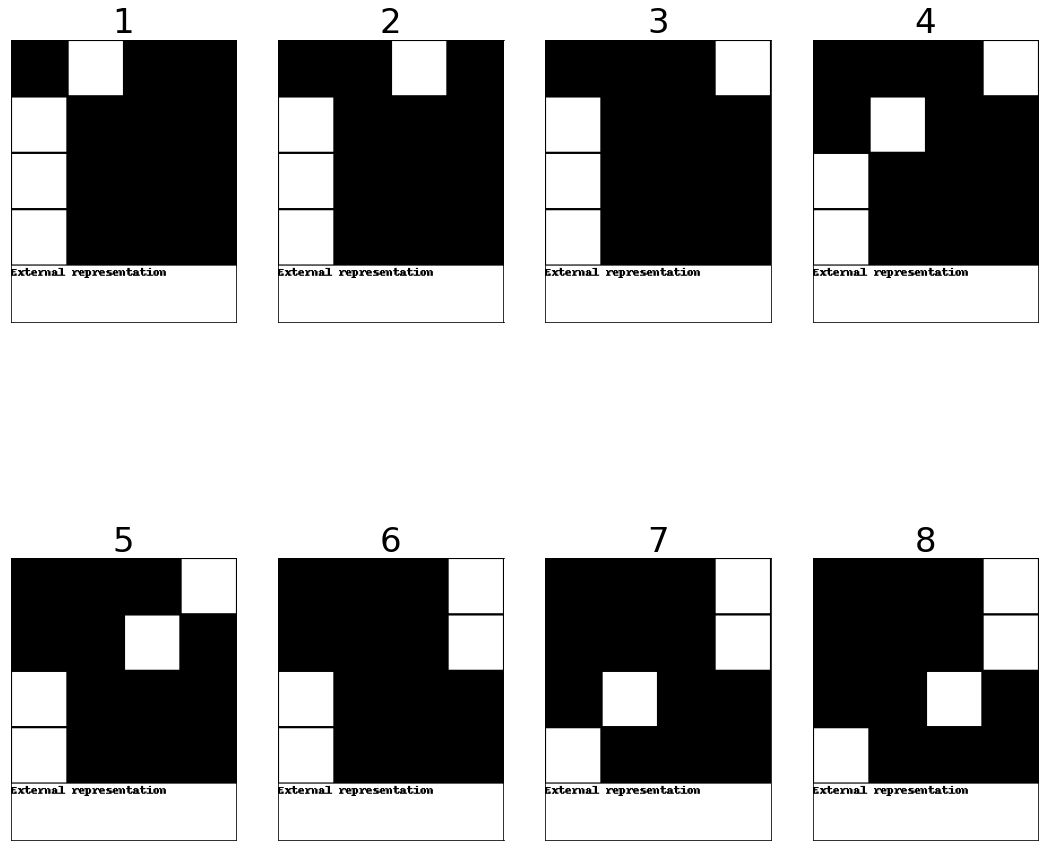

In [55]:
##############
## Plot grid of hand-crafted external representations
##########################################


##############
## Dynamic Environment Demo with Sequence of Actions
###################


agent_params = {
    'single_or_multi_agent': 'single',
    'task': 'classify',
    'external_repr_tool': 'Abacus',
    'observation': 'temporal',
    'max_objects': 2,
    'obs_dim': 4,
    'obs_shape': (4,4),
    'ext_shape': (4,4),
    'IsSubmitButton': False,
    'max_episode_length': 8,
    'curriculum_learning': False
}



if(agent_params['single_or_multi_agent'] == 'multi'):
    env = MultiAgentEnvironment(agent_params)
    env.agents[0].check_reward = False
if(agent_params['single_or_multi_agent'] == 'single'):
    env = SingleRLAgent(agent_params)
    env.check_reward = False
#env.max_episode_length = 7
env.reset()
#display(env.render(), display_id='model_demo')
grid_width = 4
grid_height = 2
fig, axs = plt.subplots(grid_height, grid_width,figsize=(15,15))
fig.tight_layout()
j_repr = -1
    
for i in range(agent_params['max_episode_length']+2):
    #env.step(['right', 'mod_point'])
    moved_token = True
    if(i==3 or i==7):
        env.step(env.all_actions_dict_inv['down'])
        moved_token = False
    else:
        env.step(env.all_actions_dict_inv['move_token_right'])
        j_repr += 1
    #update_display(env.render(), display_id='model_demo')
    #time.sleep(3)
    if(moved_token):
        img = env.render()
        ax = axs[j_repr//grid_width, j_repr%grid_width]
        ax.imshow(env.ext_repr_img)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(str(j_repr+1), fontsize=34)
    

plt.subplots_adjust(hspace=0)
    
    

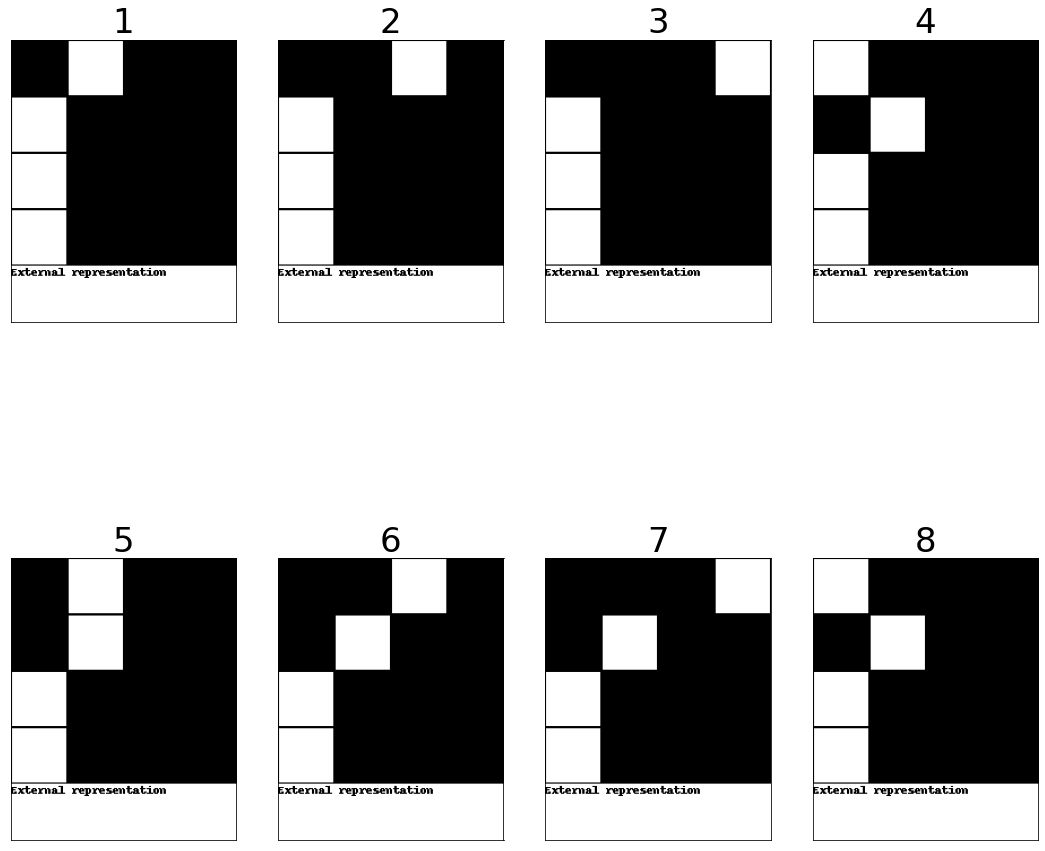

In [62]:
env.reset()
#display(env.render(), display_id='model_demo')
grid_width = 4
grid_height = 2
fig, axs = plt.subplots(grid_height, grid_width,figsize=(15,15))
fig.tight_layout()

mv_str = 'move_token_right'
action_list = [mv_str, mv_str, mv_str, mv_str, 'down', mv_str, 'up', mv_str, mv_str, mv_str, mv_str]
j_repr = -1
    
for i in range(agent_params['max_episode_length']+3):
    #env.step(['right', 'mod_point'])
    env.step(env.all_actions_dict_inv[action_list[i]])
    #update_display(env.render(), display_id='model_demo')
    #time.sleep(3)
    if(action_list[i]==mv_str and i!=3):
        j_repr += 1
        img = env.render()
        ax = axs[j_repr//grid_width, j_repr%grid_width]
        ax.imshow(env.ext_repr_img)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(str(j_repr+1), fontsize=34)
    

plt.subplots_adjust(hspace=0)

In [24]:
env.step(['move_token_right', 'move_token_right'])
update_display(env.render(), display_id='model_demo')

In [18]:
%run SingleAgent.py
%run MultiAgentEnvironment.py
%run utils.py

KeyError: 'Agent_Setup'

In [3]:
agent_params = {
    'max_objects': 4,
    'obs_dim': 4,
}

agent = SingleRLAgent(agent_params)

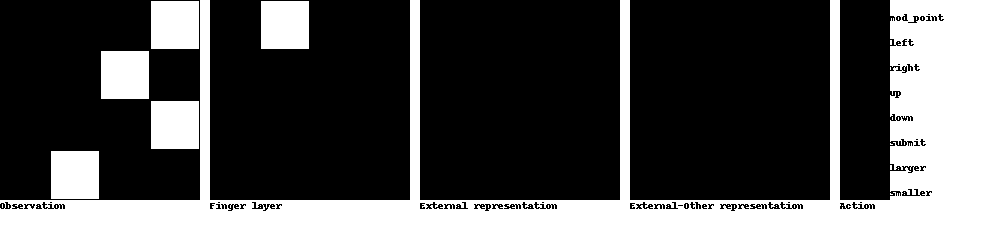

In [4]:
agent.render()

In [26]:
def demonstrate_model(model, env, collect=False, eval=True, n_objects=None):
    total_rewards = []
    summed_rewards = 0

    states = env.reset(n_objects)
    states = torch.stack([torch.unsqueeze(ptu.from_numpy(state), dim=0) for state in states]).transpose(0,1)
    t_sofar = 0
    done = False

    
    actions_during_episode = []
    img_list = []
    img_list.append(env.render(display_id="model_demo"))
    time.sleep(2)

    while not done:
        t_sofar += 1
        actions_tensors = model(states)
        action_arr = [ptu.to_numpy(actions_tensor) for actions_tensor in actions_tensors]
        actions = [np.argmax(action_arr[0], axis=1)[0], np.argmax(action_arr[1], axis=1)[0]]
        actions_during_episode.append(actions)
        next_states, reward, done, _ = env.step(actions)

        # Convert numpy objects to tensors for saving in memory
        reward = torch.tensor([ptu.from_numpy(np.array(reward))])
        actions = torch.stack([torch.unsqueeze(ptu.from_numpy(np.array(action)),dim=0) for action in actions])
        if next_states is not None:
            next_states = torch.stack([torch.unsqueeze(ptu.from_numpy(next_state), dim=0) for next_state in next_states]).transpose(0,1)

        # Move to the next state
        states = next_states


        if done:
            reward = reward.cpu().numpy().item()
            summed_rewards += reward
            total_rewards.append(reward)

        #if(eval and i_episode==0):
        #    print("act ", t_sofar, ": ", actions)
        print(actions)
        img_list.append(env.render(display_id="model_demo"))
        time.sleep(2)
    return img_list



In [ ]:
# Define Environment (2-Agents)

agent_params = {
    'max_objects': 2,
    'obs_dim': 4,
    'max_episode_length': 1,
}

# agent_params = {
#     'max_objects': 3,
#     'obs_dim': 4,
#     'max_episode_length': 3,
# }

agent_params = {
    'max_objects': 4,
    'obs_dim': 4,
    'max_episode_length': 5,
}

agent_params = {
    'max_objects': 9,
    'obs_dim': 4,
    'max_episode_length': 7,
}

agent_params = {
    'max_objects': 8,
    'obs_dim': 4,
    'max_episode_length': 8,
    'observation': 'spatial'
}




obs_ext_shape = (9,1)

agent_params = {
    'max_objects': 8,
    'obs_shape': obs_ext_shape,
    'ext_shape': obs_ext_shape,
    'max_episode_length': 8,
    'observation': 'spatial',
    'single_or_multi_agent': 'multi',
    'external_repr_tool': 'WriteCoord'
}

Working with max  2  objects


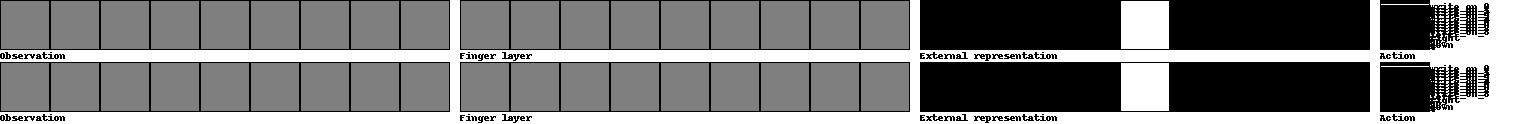

tensor([[4.],
        [4.]])
tensor([[1.],
        [1.]])
tensor([[1.],
        [1.]])


In [30]:


model_dir = data_dir + 'classify_WriteCoord_spatial_2_to_3_16-08-2021_15-37-38/'
params_file = model_dir + 'params.pickle'
model_file = model_dir + 'best_model.pt'

with open(params_file, 'rb') as f:
    agent_params = pickle.load(f)['agent_params']

agent_params['max_objects'] = 2


env = MultiAgentEnvironment(agent_params)
#env.max_episode_length = 7
env.reset()
ext_shape = env.agents[0].ext_shape
dimmy = 1 if ext_shape[1] == 1 else 2
    
display(env.render(), display_id='model_demo')

n_channels, screen_height, screen_width  = env.states[0].shape  # Assumes that all agents have same state-dim as agent[0]
n_actions = env.agents[0].action_dim
#model = N_Concat_CNNs(n_channels, n_actions, shared_policy=False)
model = N_Concat_CNNs(n_channels, n_actions, shared_policy=True, example_input = env.states, dim=dimmy)
# Successful 2
#model.load_state_dict(torch.load('/home/silvester/programming/rl-communicating-numbers/counting-agents/src/../data/TODO_30-04-2021_16-16-33/model.pt'))
# Successful 3
#model.load_state_dict(torch.load('/home/silvester/programming/rl-communicating-numbers/counting-agents/src/../data/TODO_03-05-2021_11-34-15/model.pt'))
# Successful 4
#model.load_state_dict(torch.load('/home/silvester/programming/rl-communicating-numbers/counting-agents/src/../data/TODO_03-05-2021_13-03-38/model.pt'))
# almost - Successful 5
#model.load_state_dict(torch.load('/home/silvester/programming/rl-communicating-numbers/counting-agents/src/../data/TODO_03-05-2021_14-22-02/model.pt'))
# 60 % for 9
#model.load_state_dict(torch.load('/home/silvester/programming/rl-communicating-numbers/counting-agents/src/../data/TODO_04-05-2021_13-36-48/model.pt'))
# 82 % for 9
#model.load_state_dict(torch.load('/home/silvester/programming/rl-communicating-numbers/counting-agents/src/../data/TODO_04-05-2021_22-08-07/model.pt'))
# Classify to 5 82 %
#model.load_state_dict(torch.load('/home/silvester/programming/rl-communicating-numbers/counting-agents/src/../data/TODO_05-05-2021_18-37-48/model.pt'))
# Classify to 5 95 %
#model.load_state_dict(torch.load('/home/silvester/programming/rl-communicating-numbers/counting-agents/src/../data/TODO_07-05-2021_11-03-33/model.pt'))
# even more: TODO_07-05-2021_11-32-52
# Reproduce up til 8 objects: 
#model.load_state_dict(torch.load('/home/silvester/programming/rl-communicating-numbers/counting-agents/src/../data/TODO_11-05-2021_11-30-16/model.pt'))
model.load_state_dict(torch.load(model_file), strict=False)




img_list = demonstrate_model(model, env, n_objects=[2,3])

In [38]:
a = np.zeros((4, 4))
a.ravel()[np.random.choice(4*4, 8, replace=False)] = 1
print(a)
print(a.sum())

[[1. 1. 0. 1.]
 [1. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 1.]]
8.0


In [135]:
test_dict = {
    0: '0',
    1: '1',
    2: '2',
}
len(test_dict)

3

In [56]:
interact(img_slider,t=(0, len(img_list)-1, 1));

interactive(children=(IntSlider(value=2, description='t', max=4), Output()), _dom_classes=('widget-interact',)…

In [70]:
imageio.mimsave('../results/animations/comparison_up_3_2_vs_3.gif', img_list, duration=2)

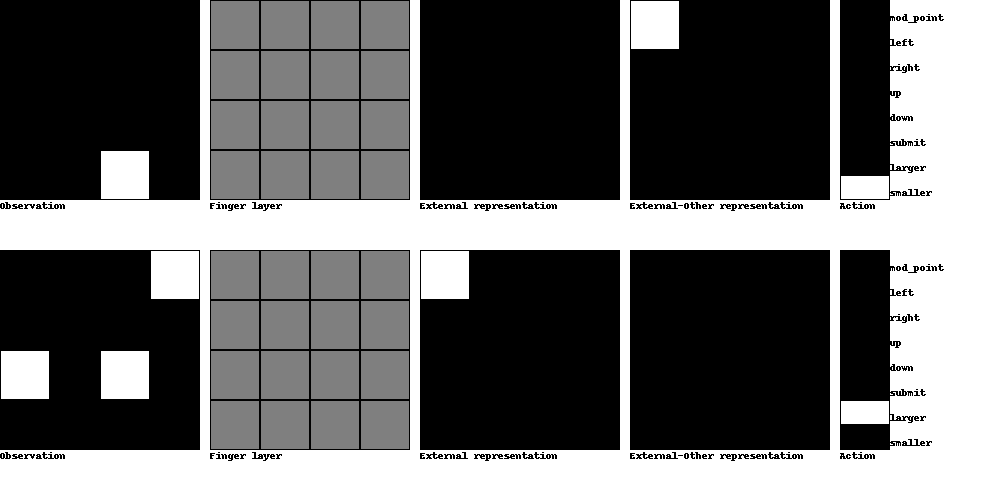

In [43]:
def img_slider(t):
    display(img_list[t], display_id="slider_display")
    
img_slider(0)


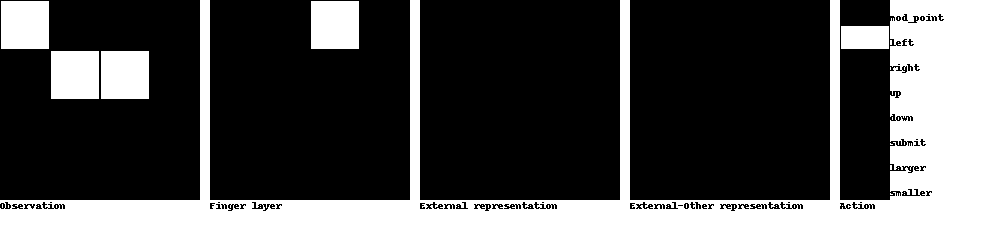

In [5]:
action = 'left'
agent.step(action)
agent.render()

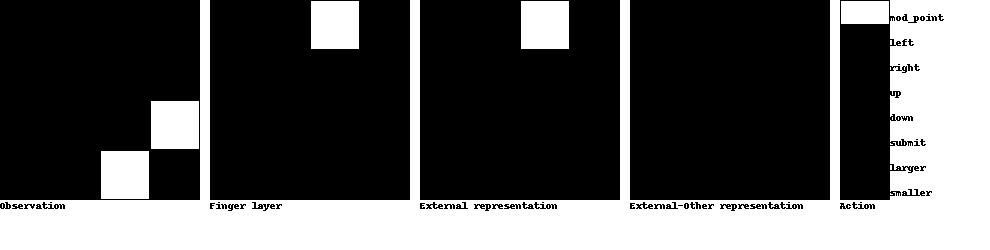

In [6]:
### Create a gif with sample actions
import imageio
import time

agent_params = {
    'max_objects': 4,
    'obs_dim': 4,
}

agent = SingleRLAgent(agent_params)
display(agent.render(), display_id="demo")

images = []
images.append(agent.render())

n_steps = 5
for i in range(n_steps):
    action = n_steps-i-1 #random.randint(0, agent.action_dim-1)
    agent.step(action)
    agent.render(display_id="demo")
    time.sleep(1)
    #images.append(agent.render())
#imageio.mimsave('env_demo_2.gif', images, fps=0.5)

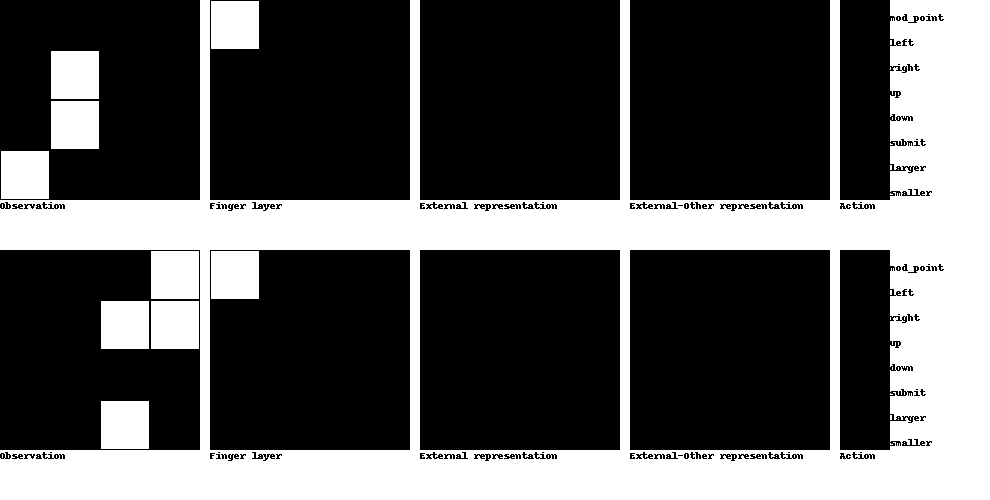

In [3]:
### Create a gif with sample actions
import imageio
import time

agent_params = {
    'max_objects': 4,
    'obs_dim': 4,
}

agent = MultiAgentEnvironment(agent_params)
agent.render()

# images = []
# images.append(agent.render())

# n_steps = 5
# for i in range(n_steps):
#     action = n_steps-i-1 #random.randint(0, agent.action_dim-1)
#     agent.step(action)
#     plt.show(agent.render(display_id="demo"))
#     time.sleep(1)
#     images.append(agent.render())

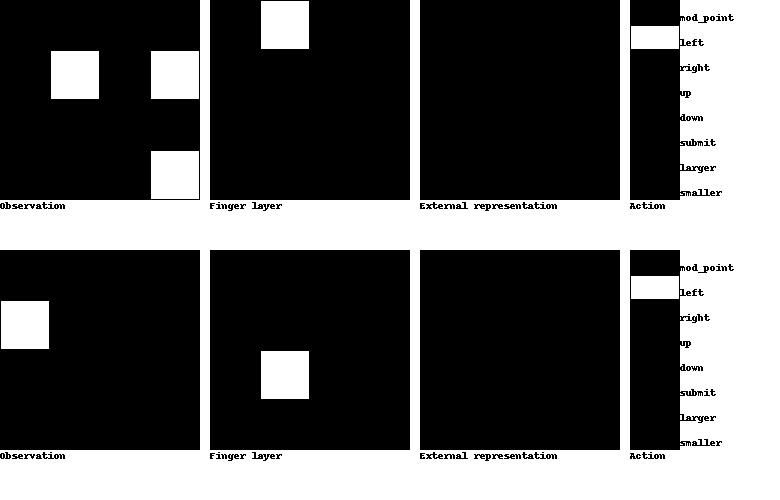

Reward:  0
Done:  True


In [11]:
_, reward, done, _ = agent.step(['left', 'left'])
display(agent.render(), display_id='game')
print("Reward: ", reward)
print("Done: ", done)

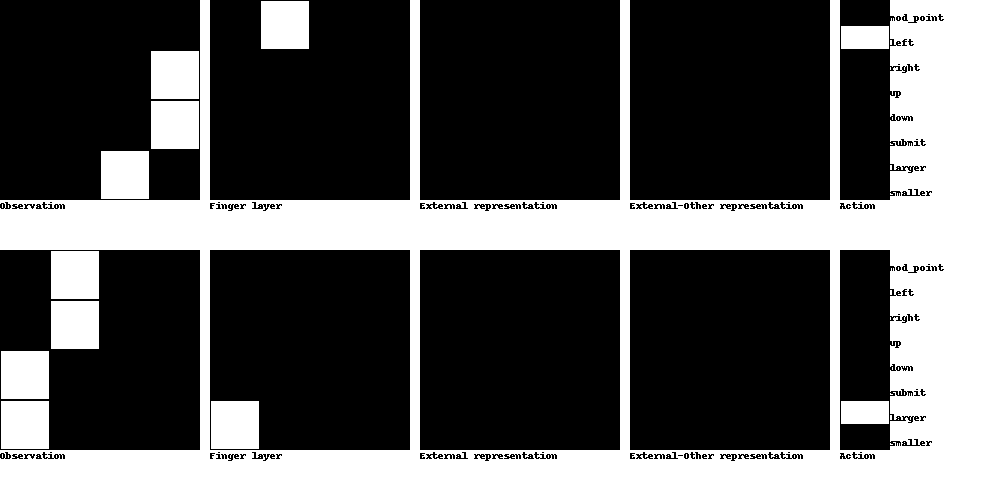

Reward:  0
Done:  False
Reward:  0
Done:  False
Reward:  1
Done:  True


In [9]:
action_list = [['left', 'left'], ['smaller', 'left'], ['left', 'larger']]
display(agent.render(), display_id='multi_game')

for action in action_list:
    _, reward, done, _ = agent.step(action)
    img = agent.render(display_id="multi_game")
    time.sleep(1)
    print("Reward: ", reward)
    print("Done: ", done)

In [14]:
action = ['mod_point', 'left']
_, reward, done, _ = agent.step(action)
img = agent.render(display_id="multi_game")

In [48]:
n_range = np.arange(1, 4+1)
print("n_range: ", n_range)

n_objects = np.random.choice(n_range, 2, replace=False)
print(n_objects)

n_range:  [1 2 3]
[1 2]


In [26]:
env.max_episode_length

3

In [4]:
def funcy():
    print("here we go")

def funcy2():
    print("here we go 2")
    
class ExperimentSetup():
    def __init__(self, func_i):
        
        self.vari = 0
        self.incry()
        self.reward_funcy = func_i

    def reward_function(self):
        self.reward_funcy()
    def env_update(self):
        pass
    def update_state(self):
        state = np.stack([self.obs, self.fingerlayer.fingerlayer, self.ext_repr.externalrepresentation])
        return state
    
    def incry(self):
        self.vari += 1

In [3]:
def iteraty():
    l = 2
    for i in range(10000000):
        l += 1

In [4]:
import cProfile
cProfile.run('iteraty()')

         4 function calls in 0.392 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.392    0.392    0.392    0.392 <ipython-input-3-ebc7f820c210>:1(iteraty)
        1    0.000    0.000    0.392    0.392 <string>:1(<module>)
        1    0.000    0.000    0.392    0.392 {built-in method builtins.exec}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}




In [42]:
for n in range(6):
    print(random.randint(2,3))

3
2
2
2
2
2


In [18]:
def calc_event_timesteps(n_objects):
    big_timestep_range_from_n = 5
    small_timestep_range = [1,2]
    big_timestep_range = [2,3]
    timestep_range = small_timestep_range

    event_timesteps = []
    t_n = 0

    for n in range(1,n_objects+1):
        if(n==big_timestep_range_from_n):
            timestep_range = big_timestep_range
        t_n += random.randint(timestep_range[0],timestep_range[1])
        event_timesteps.append(t_n)
        
    return event_timesteps
    
def calc_max_episode_length(n_objects, observation):
    if(observation == 'spatial'):
        return 1*n_objects-1
    elif(observation == 'temporal'):
        #return 1*n_objects+1

        big_timestep_range_from_n = 5
        max_time_length = min(big_timestep_range_from_n - 1, n_objects) * 2
        # + max(0,max_objects-big_timestep_range_from_n)*3
        if (n_objects >= big_timestep_range_from_n):
            max_time_length += (n_objects - big_timestep_range_from_n+1) * 3
        return max_time_length
    
n_objects = 5
event_timesteps = calc_event_timesteps(n_objects)
max_episode_length = calc_max_episode_length(n_objects, observation='temporal')
print("event_timesteps: ", event_timesteps)
print("max_episode_length: ", max_episode_length)


event_timesteps:  [2, 3, 5, 7, 9]
max_episode_length:  11


In [20]:
ext_repr_imgs = {i: [] for i in range(1, 5)}
print(ext_repr_imgs)
ext_repr_imgs[1].append(5)
print(ext_repr_imgs)

{1: [], 2: [], 3: [], 4: []}
{1: [5], 2: [], 3: [], 4: []}
